In [74]:
import pandas as pd 
import numpy as np
from scipy.signal import correlate, correlation_lags
import scipy.cluster.hierarchy as hcluster
from datetime import datetime
import seaborn as sns
import requests
from pprint import pprint
import copy
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import statsmodels.api as sm
from scipy import stats
from datetime import datetime, timedelta
import itertools
import matplotlib.dates as mdates
import plotly.graph_objects as go 
fmt = mdates.DateFormatter('%d-%b\n%Y') 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%d-%b\n%Y')  
import matplotlib.pyplot as plt
import warnings
#from translate import Translator
warnings.filterwarnings("ignore")

## Getting the data from FOPH
The URLs for downloading the data can be updated daily so that we can download the lates data.

In [75]:
all_cantons = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FL', 'FR', 'GE', 'GL', 'GR', 'JU',
       'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD',
       'VS', 'ZG', 'ZH']

context_url = "https://www.covid19.admin.ch/api/data/context"
context = requests.get(context_url).json()
pprint(context['sources']['individual']['csv']['daily'])

{'cases': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Cases_geoRegion.csv',
 'casesVaccPersons': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Cases_vaccpersons.csv',
 'covidCertificates': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Certificates.csv',
 'death': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Death_geoRegion.csv',
 'deathVaccPersons': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Death_vaccpersons.csv',
 'hosp': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Hosp_geoRegion.csv',
 'hospCapacity': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19HospCapacity_geoRegion.csv',
 'hospVaccPersons': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19Hosp_vaccpersons.csv',
 'intCases': 'https://www.covid19.admin.ch/api/data/20220119-zzv1wmzq/sources/COVID19IntCases.csv',
 're': 'ht

In [76]:
def get_cluster_data(curve, georegion):
    
    '''
    This function provide a dataframe with the curve selected in the param curve for each region selected in the 
    param georegion
    
    param curve: string. The following options are accepted: ['cases', 'death',
                                                              'hosp', 'hospCapacity', 
                                                              're', 'test', 'testPcrAntigen', 'virusVariantsWgs']
    param georegion: array with all the geoRegions of interest.
    
    return dataframe
    '''

    
    context_url = "https://www.covid19.admin.ch/api/data/context"
    context = requests.get(context_url).json()
    
    
    if (curve=='hospCapacity'):
        df = pd.read_csv(context['sources']['individual']['csv']['daily'][curve],
                     usecols=['geoRegion','date','ICU_Covid19Patients'])
        df.index = pd.to_datetime(df.date)
        
    else: 
        df = pd.read_csv(context['sources']['individual']['csv']['daily'][curve],
                     usecols=['geoRegion','datum','entries'])
        df.index = pd.to_datetime(df.datum)
    
    # dataframe where will the curve for each region
    
    df_end = pd.DataFrame()
    
    for i in georegion:

        if curve == 'hospCapacity':
            df_end['ICU_patients_'+i] = df.loc[df.geoRegion == i].ICU_Covid19Patients
        else:
            df_end[curve+'_'+i] = df.loc[df.geoRegion == i].entries
    df_end = df_end.resample('D').mean()   
    return df_end

def get_combined_data( data_types, georegion,vaccine = True, smooth = True):
    
    '''
    This function provide a dataframe with the all the curves selected in the param data_types for each region selected in the 
    param georegion
    
    param data_types: array. The following options are accepted: ['cases', 'casesVaccPersons', 'covidCertificates', 'death',
                                                             'deathVaccPersons', 'hosp', 'hospCapacity', 'hospVaccPersons',
                                                             'intCases', 're', 'test', 'testPcrAntigen', 'virusVariantsWgs']
    param georegion: array with all the geoRegions of interest.
    
    return dataframe
    '''

    for i in np.arange(0, len(data_types)):
        
        if i == 0:
            
            df = get_cluster_data(data_types[i], georegion)
            
        else:
            
            df = df.merge(get_cluster_data(data_types[i], georegion), left_index =True, right_index = True)
    
    
    if vaccine == True:
        ## adicionando os dados de vacinação para a suiça disponibilizados pelo 
        ## Our World in Data
        vac = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
        
        # selecionando apenas os dados da suiça 
        vac = vac.loc[vac.iso_code == 'CHE']
        vac.index = pd.to_datetime(vac.date)
        
        vac = vac[['total_vaccinations_per_hundred']]
        
        vac = vac.fillna(0)
        
        if vac.total_vaccinations_per_hundred[-1] == 0:
            vac.total_vaccinations_per_hundred[-1] = vac.total_vaccinations_per_hundred[-2]
    
        
        df['vac_all'] = vac.total_vaccinations_per_hundred
        
    
    # filling the NaN values by zero 
    df = df.fillna(0)
    
    if smooth == True:
        df = df.rolling(window = 7).mean()
        
        df = df.dropna()

        
    return df 

# get_combined_data(['hospCapacity','hosp'], georegion=all_cantons)

In [77]:
def get_lag(x,y,maxlags=5, smooth=True):
    if smooth:
        x = pd.Series(x).rolling(7).mean().dropna().values
        y = pd.Series(y).rolling(7).mean().dropna().values
    corr = correlate(x,y, mode='full')/np.sqrt(np.dot(x,x)*np.dot(y,y))
    slice = np.s_[(len(corr)-maxlags)//2:-(len(corr)-maxlags)//2]
    corr = corr[slice]
    lags = correlation_lags(x.size,y.size,mode='full')
    lags = lags[slice]
    lag = lags[np.argmax(corr)]
    

#     lag = np.argmax(corr)-(len(corr)//2)

    return lag, corr.max()

def lag_ccf(a,maxlags=30,smooth=True):
    """
    Calculate the full correlation matrix based on the maximum correlation lag 
    """
    ncols = a.shape[1]
    lags = np.zeros((ncols,ncols))
    cmat = np.zeros((ncols,ncols))
    for i in range(ncols): 
        for j in range(ncols):
#             if j>i:
#                 continue
            lag, corr = get_lag(a.T[i],a.T[j], maxlags, smooth)
            cmat[i,j] = corr
            lags[i,j] = lag
    return cmat,lags

In [78]:
def compute_clusters(curve, t, plot = True):
    '''
    Function to compute the clusters 
    
    param curve: string. Represent the curve that will used to cluster the regions.
    
    param t: float. Represent the value used to compute the distance between the cluster and so 
    decide the number of clusters 
    
    return: array. 
    -> cluster: is the array with the computed clusters
    -> all_regions: is the array with all the regions
    '''
    context_url = "https://www.covid19.admin.ch/api/data/context"
    context = requests.get(context_url).json()
    
    df = pd.read_csv(context['sources']['individual']['csv']['daily'][curve])
    
    inc_canton = df.pivot(columns='geoRegion', values='entries')
    
    # Computing the correlation matrix based on the maximum correlation lag 
    
    del inc_canton['CHFL']
    
    del inc_canton['CH']
    
    cm,lm=lag_ccf(inc_canton.values)
    
    # Plotting the dendrogram
    linkage = hcluster.linkage(cm, method='complete')
   
    if plot == True:
        fig, ax = plt.subplots(1,1, figsize=(15,10), dpi = 100)
        hcluster.dendrogram(linkage, labels=inc_canton.columns, color_threshold=0.3, ax=ax)
        plt.show()
    
    # computing the cluster 
    
    ind = hcluster.fcluster(linkage, t, 'distance')

    grouped = pd.DataFrame(list(zip(ind,inc_canton.columns))).groupby(0) # preciso entender melhor essa linha do código 
    clusters = [group[1][1].values for group in grouped]
    
    all_regions = df.geoRegion.unique() 
    
    return clusters, all_regions

def build_lagged_features(dt, maxlag=2, dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    :param dt: Dataframe containing features
    :param maxlag: maximum lags to compute
    :param dropna: if true the initial rows containing NANs due to lagging will be dropped
    :return: Dataframe
    '''
    if type(dt) is pd.DataFrame:
        new_dict = {}
        for col_name in dt:
            new_dict[col_name] = dt[col_name]
            # create lagged Series
            for l in range(1, maxlag + 1):
                new_dict['%s_lag%d' % (col_name, l)] = dt[col_name].shift(l)
        res = pd.DataFrame(new_dict, index=dt.index)

    elif type(dt) is pd.Series:
        the_range = range(maxlag + 1)
        res = pd.concat([dt.shift(i) for i in the_range], axis=1)
        res.columns = ['lag_%d' % i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res
    
def lgbm_model(alpha = 0.5, params=None, **kwargs):
    '''
    Return an LGBM model
    :param kwargs:
    :return: LGBMRegressor model
    '''
    if params is None:
        params = {
            'n_jobs': 8,
            'max_depth': 4,
            'max_bin': 63,
            'num_leaves': 255,
#             'min_data_in_leaf': 1,
            'subsample': 0.9,
            'n_estimators': 200,
            'learning_rate': 0.1,
            'colsample_bytree': 0.9,
            'boosting_type': 'gbdt'
        }

    model = lgb.LGBMRegressor(objective='quantile', alpha = alpha, **params)

    return model 

In [79]:
def rolling_predictions(target_name, data,hosp_as_predict, ini_date = '2020-03-01',split = 0.25, horizon_forecast = 14, maxlag=14):
    '''Train multiple models. One for each prediction delta
    :param df_train: training dataframe 
    :param horizon_forecast: Horizon (maximum forecast range)
    :param maxlag: number of past days to consider
    :param neighbours: knn parameter
    :return: Prediction'''
    
    target = data[target_name]
    
    if hosp_as_predict == False: 
        
        for i in data.columns:
            
            if i.startswith('hosp') == True:
                data = data.drop(i, axis = 1)
        
    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )
    
    #print(type(df_lag.index[0]))
    #print(target.index[0])
    
    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))
    
    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()
        

    
    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)

    
    # targets 
    targets = {}

    for T in np.arange(1,horizon_forecast+1,1):
        if T == 1:
            targets[T] = target.shift(-(T - 1))
        else:
            targets[T] = target.shift(-(T - 1))[:-(T - 1)]
#         print(T, len(df_lag), len(fit_target))
#         print(df_lag.index,fit_target.index)

    
        
    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)
        
    
    # predictions 
    preds5 = np.empty((len(df_lag), horizon_forecast))
    preds50 = np.empty((len(df_lag), horizon_forecast))
    preds95 = np.empty((len(df_lag), horizon_forecast))
    
    forecasts5 = []
    forecasts50 = []
    forecasts95 = []
    
    for T in range(1, horizon_forecast + 1):
        
        tgt = targets[T][:len(X_train)]
        
        #tgtt = targets[T][len(X_train)]
        model5 = lgbm_model(alpha = 0.025)
        model50 = lgbm_model(alpha = 0.5)
        model95 = lgbm_model(alpha = 0.975)
        
        model5.fit(X_train, tgt)
        model50.fit(X_train, tgt)
        model95.fit(X_train, tgt)
        
        #dump(model, f'saved_models/{estimator}_{target_name}_{T}.joblib')
        
        pred5 = model5.predict(df_lag.iloc[:len(targets[T])])
        pred50 = model50.predict(df_lag.iloc[:len(targets[T])])
        pred95 = model95.predict(df_lag.iloc[:len(targets[T])])

        dif = len(df_lag) - len(pred5)
        if dif > 0:
            pred5 = list(pred5) + ([np.nan] * dif)
            
        dif = len(df_lag) - len(pred50)
        if dif > 0:
            pred50 = list(pred50) + ([np.nan] * dif)
            
        dif = len(df_lag) - len(pred95)
        if dif > 0:
            pred95 = list(pred95) + ([np.nan] * dif)
        
        preds5[:, (T - 1)] = pred5
        preds50[:, (T - 1)] = pred50
        preds95[:, (T - 1)] = pred95
        
        forecast5 = model5.predict(df_lag.iloc[-1:])
        forecast50 = model50.predict(df_lag.iloc[-1:])
        forecast95 = model95.predict(df_lag.iloc[-1:])
        
        forecasts5.append(forecast5)
        forecasts50.append(forecast50)
        forecasts95.append(forecast95)
               
        
    # transformando preds em um array
    train_size = len(X_train)
    point = targets[1].index[train_size]

    pred_window = preds5.shape[1]
    llist = range(len(targets[1].index) - (preds5.shape[1]))

    y5 = []
    y50 = []
    y95 = []
    
    x=[]
    for n in llist:
        x.append(targets[1].index[n + pred_window])
        y5.append(preds5[n][-1])
        y50.append(preds50[n][-1])
        y95.append(preds95[n][-1])
        
    forecast_dates = []

    last_day = datetime.strftime(np.array(x)[-1], '%Y-%m-%d')

    a = datetime.strptime(last_day, '%Y-%m-%d')
    
    for i in np.arange(1, horizon_forecast + 1):

        d_i = datetime.strftime(a+timedelta(days=int(i)),'%Y-%m-%d' ) 

        forecast_dates.append(datetime.strptime(d_i, '%Y-%m-%d'))

    return (np.array(x), np.array(y5),np.array(y50), np.array(y95),  targets[1], 
            len(X_train), forecast_dates, np.array(forecasts5)[:,0], np.array(forecasts50)[:,0],
            np.array(forecasts95)[:,0])

In [80]:
def plot_predictions(target_curve_name, canton, target, train_size, x, y5,y50, y95, forecast_dates, forecasts5, forecasts50,forecasts95, title, path):
    ''''
    Function to plot the predictions
    '''
    
    point = target.index[train_size]
    min_val = min([min(target), np.nanmin(y50)])
    max_val = max([max(target), np.nanmax(y50)])

    point_date = np.where(target.index == '2021-01-01')

    fig = go.Figure()
    
    # Dict with names for the curves 
    names = {'hosp': 'Hospitalization', 'ICU_patients': 'ICU patients'}
    
    if title == None: 
        
        title = f"{names[target_curve_name]} - {canton}"

    fig.update_layout(width=900, height=500, title={
            'text': title,
            'y':0.87,
            'x':0.42,
            'xanchor': 'center',
            'yanchor': 'top'},
    xaxis_title='Date',
    yaxis_title=f'{names[target_curve_name]}',
    template = 'plotly_white')

    # adicionando os traços 

    # Data
    fig.add_trace(go.Scatter(x = target.index, y = target.values, name = 'Data',line=dict(color = 'black')))
    
    #fig.add_trace(go.Scatter(x = get_real_data('2021-12-09').index, y = get_real_data('2021-12-09').ID.values, name = 'Updated Data',line=dict(color = 'green')))

    #print(get_real_data(target.index[0]).index)
    # separação entre os dados de treino e de teste
    fig.add_trace(go.Scatter(x=[point, point], y=[min_val,max_val], name="Out of sample predictions", mode = 'lines',line=dict(color = '#1CA71C', dash = 'dash')))

    # Separação entre os dados de teste e o forecast
    fig.add_trace(go.Scatter(x=[target.index[-1], target.index[-1]], y=[min_val,max_val], name="Forecast", mode = 'lines',line=dict(color = '#FB0D0D', dash = 'dash')))

    # KNN
    # LightGBM
    fig.add_trace(go.Scatter(x = x, y = y50, name = 'LightGBM',line=dict(color = '#FF7F0E')))
    
    fig.add_trace(go.Scatter(x = x, y = y5, line=dict(color = '#FF7F0E',width=0), showlegend=False))
    
    fig.add_trace(go.Scatter(x = x, y = y95,line=dict(color = '#FF7F0E', width=0),
        mode='lines',
        fillcolor='rgba(255, 127, 14, 0.3)', fill = 'tonexty', showlegend= False))

    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecasts50, name = 'Forecast LightGBM', line=dict(color = 'rgb(230, 57, 18)')))
    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecasts5, mode = 'lines', line=dict(color = 'rgb(230, 57, 18)', width =0), showlegend = False))
    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecasts95,line=dict(color = 'rgb(230, 57, 18)', width=0),
        mode='lines',
        fillcolor='rgba(230, 57, 18, 0.3)', fill = 'tonexty', showlegend = False))
    
    
    fig.update_xaxes( showgrid=True, gridwidth=1, gridcolor='lightgray',zeroline = False,
    showline=True, linewidth=1, linecolor='black', mirror = True)

    fig.update_yaxes( showgrid=True, gridwidth=1, gridcolor='lightgray', zeroline = False,
    showline=True, linewidth=1, linecolor='black', mirror = True)

    if path == None: 
        path = f"images/hosp_{canton}.png"
    fig.write_image(path)
    #pio.write_image(fig, "images/hosp_GE.png", width=900*300, height=500*300, scale=1)

    fig.show()
    
    

In [81]:
# compute the clusters 
clusters, all_regions = compute_clusters('hosp', t=0.8, plot = False)

def plot_hybrid_predictions(target_curve_name, canton, target, train_size, x, y5,y50, y95, yglm, forecast_dates, forecasts5, forecasts50,forecasts95, forecastsglm, title, path):
    ''''
    Function to plot the predictions
    '''
    
    point = target.index[train_size]
    min_val = min([min(target), np.nanmin(y50)])
    max_val = max([max(target), np.nanmax(y50)])

    point_date = np.where(target.index == '2021-01-01')

    fig = go.Figure()
    
    # Dict with names for the curves 
    names = {'hosp': 'Hospitalization', 'ICU_patients': 'ICU patients'}
    
    if title == None: 
        
        title = f"{names[target_curve_name]} - {canton}"

    fig.update_layout(width=900, height=500, title={
            'text': title,
            'y':0.87,
            'x':0.42,
            'xanchor': 'center',
            'yanchor': 'top'},
    xaxis_title='Date',
    yaxis_title=f'{names[target_curve_name]}',
    template = 'plotly_white')

    # adicionando os traços 

    # Data
    fig.add_trace(go.Scatter(x = target.index, y = target.values, name = 'Data',line=dict(color = 'black')))
    
    #fig.add_trace(go.Scatter(x = get_real_data('2021-12-09').index, y = get_real_data('2021-12-09').ID.values, name = 'Updated Data',line=dict(color = 'green')))

    #print(get_real_data(target.index[0]).index)
    # separação entre os dados de treino e de teste
    fig.add_trace(go.Scatter(x=[point, point], y=[min_val,max_val], name="Out of sample predictions", mode = 'lines',line=dict(color = '#1CA71C', dash = 'dash')))

    # Separação entre os dados de teste e o forecast
    fig.add_trace(go.Scatter(x=[target.index[-1], target.index[-1]], y=[min_val,max_val], name="Forecast", mode = 'lines',line=dict(color = '#FB0D0D', dash = 'dash')))

    # KNN
    # LightGBM
    fig.add_trace(go.Scatter(x = x, y = y50, name = 'LightGBM',line=dict(color = '#FF7F0E')))
    
    fig.add_trace(go.Scatter(x = x, y = y5, line=dict(color = '#FF7F0E',width=0), showlegend=False))
    
    fig.add_trace(go.Scatter(x = x, y = y95,line=dict(color = '#FF7F0E', width=0),
        mode='lines',
        fillcolor='rgba(255, 127, 14, 0.3)', fill = 'tonexty', showlegend= False))
    
    fig.add_trace(go.Scatter(x = x, y = yglm,name='GLM',line=dict(color = '#FF7FEE', width=0),
        mode='lines', showlegend= False))

    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecasts50, name = 'Forecast LightGBM', line=dict(color = 'rgb(230, 57, 18)')))
    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecasts5, mode = 'lines', 
                             line=dict(color = 'rgb(230, 57, 18)', width =0), showlegend = False))
    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecasts95,line=dict(color = 'rgb(230, 57, 18)', width=0),
        mode='lines',
        fillcolor='rgba(230, 57, 18, 0.3)', fill = 'tonexty', showlegend = False))
    
    fig.add_trace(go.Scatter(x = forecast_dates, y = forecastsglm, name='GLM forecast',line=dict(color = 'rgb(210, 57, 18)', width=0),
        mode='markers+lines', showlegend = False))
    
    
    fig.update_xaxes( showgrid=True, gridwidth=1, gridcolor='lightgray',zeroline = False,
    showline=True, linewidth=1, linecolor='black', mirror = True)

    fig.update_yaxes( showgrid=True, gridwidth=1, gridcolor='lightgray', zeroline = False,
    showline=True, linewidth=1, linecolor='black', mirror = True)

    if path == None: 
        path = f"images/hosp_{canton}.png"
    fig.write_image(path)
    #pio.write_image(fig, "images/hosp_GE.png", width=900*300, height=500*300, scale=1)

    fig.show()
    
    

def rolling_hybrid(target_name, data,hosp_as_predict, ini_date = '2020-03-01',split = 0.25, horizon_forecast = 14, maxlag=14):
    '''Train multiple models. One for each prediction delta
    :param df_train: training dataframe 
    :param horizon_forecast: Horizon (maximum forecast range)
    :param maxlag: number of past days to consider
    :param neighbours: knn parameter
    :return: Prediction'''
    
    target = data[target_name]
    
    if hosp_as_predict == False: 
        
        for i in data.columns:
            
            if i.startswith('hosp') == True:
                data = data.drop(i, axis = 1)
        
    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag )
    
    #print(type(df_lag.index[0]))
    #print(target.index[0])
    
    ini_date = max(df_lag.index[0],target.index[0], datetime.strptime(ini_date, "%Y-%m-%d"))
    
    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    df_lag = df_lag.dropna()
        

    
    # remove the target column and columns related with the day that we want to predict 
    df_lag = df_lag.drop(data.columns, axis = 1)

    
    # targets 
    targets = {}

    for T in np.arange(1,horizon_forecast+1,1):
        if T == 1:
            targets[T] = target.shift(-(T - 1))
        else:
            targets[T] = target.shift(-(T - 1))[:-(T - 1)]
#         print(T, len(df_lag), len(fit_target))
#         print(df_lag.index,fit_target.index)

    
        
    X_train, X_test, y_train, y_test = train_test_split(df_lag, target, train_size=split, test_size=1 - split, shuffle=False)
    
    idx = pd.period_range(start=df_lag.index[0], end=df_lag.index[-1], freq='14D')
        
    idx = idx.to_timestamp()
    
    # predictions 
    preds5 = np.empty((len(idx), horizon_forecast))
    preds50 = np.empty((len(idx), horizon_forecast))
    preds95 = np.empty((len(idx), horizon_forecast))
    predsglm = np.empty((len(idx), horizon_forecast))
    
    forecasts5 = []
    forecasts50 = []
    forecasts95 = []
    forecastsglm = []
    
    for T in range(1, horizon_forecast + 1):
        
        tgt = targets[T][:len(X_train)]
        
        #tgtt = targets[T][len(X_train)]
        model5 = lgbm_model(alpha = 0.025)
        model50 = lgbm_model(alpha = 0.5)
        model95 = lgbm_model(alpha = 0.975)
        
        model5.fit(X_train, tgt)
        model50.fit(X_train, tgt)
        model95.fit(X_train, tgt)
        
        # Build the GLM model
        glm_poisson  = sm.GLM(tgt, X_train,family=sm.families.Poisson())
        glm_res = glm_poisson.fit()
        
        # print(glm_res.summary())
        
        #dump(model, f'saved_models/{estimator}_{target_name}_{T}.joblib')
        
        pred5 = model5.predict(df_lag.loc[idx])
        pred50 = model50.predict(df_lag.loc[idx])
        pred95 = model95.predict(df_lag.loc[idx])
        predglm = glm_res.predict(df_lag.loc[idx])

        
        preds5[:, (T - 1)] = pred5
        preds50[:, (T - 1)] = pred50
        preds95[:, (T - 1)] = pred95
        predsglm[:, (T - 1)] = predglm
        
               
        
    # transformando preds em um array
    train_size = len(X_train)
    point = targets[1].index[train_size]

    pred_window = preds5.shape[1]
    llist = range(len(targets[1].index) - (preds5.shape[1]))

    y5 = preds5.flatten()
    y50 = preds50.flatten()
    y95 = preds95.flatten()
    yglm = predsglm.flatten()

    x= pd.period_range(start=df_lag.index[1], end=df_lag.index[-1], freq='D').to_timestamp()
        
    x = np.array(x)
        
    y5 = np.array(y5)
        
    y50 = np.array(y50)
        
    y95 = np.array(y95)
    
    yglm = yglm
        
    target = targets[1]
        
    train_size = len(X_train)
        
    dif = len(x) - len(y5)
            
    if dif <0:
        y5 = y5[:len(y5) + dif]
        y50 = y50[:len(y50) + dif]
        y95 = y95[:len(y95) + dif]
        yglm = yglm[:len(yglm) + dif]
        
    
    
    return np.array(x), np.array(y5),np.array(y50), np.array(y95), np.array(yglm),  targets[1], len(X_train)

def hybrid_prediction(target_curve_name, canton, predictors, vaccine = True, 
                           smooth= True, hosp_as_predict = False,ini_date = '2020-03-01', 
                           title = None, path = None):
    
    '''
    Function to make single prediction 
    
    Important: 
    * By default the function is using the clustering cantons and the data since 2020
    * For the predictor hospCapacity is used as predictor the column ICU_Covid19Patients
    
    params target_curve_name: target of the forecast.
    params canton: canton of interest 
    params predictors: variables that  will be used in model 
    params vaccine: It determines if the vaccine data from owid will be used or not 
    params smooth: It determines if data will be smoothed or not 
    params hosp_as_predict: It determines if hosp cruves will be use as predictors or not 
    params ini_date: Determines the beggining of the train dataset
    params title: If none the title will be: Hospitalizations - canton
    params path: If none the plot will be save in the directory: images/hosp_{canton}
    '''
    
    # find the cluster of the canton
    for cluster in clusters:
        if canton in cluster:
            cluster_canton = cluster
            
    
    # getting the data 
    df = get_combined_data(predictors, cluster_canton, vaccine=vaccine, smooth = smooth)
    # filling the nan values with 0
    df = df.fillna(0)
    
    target_name = f'{target_curve_name}_{canton}'
    
    horizon = 14
    maxlag = 14
    
    # Get the redictions from gbm model
    x, y5,y50, y95,yglm,target,train_size, forecast_dates, forecasts5, forecasts50,forecasts95, forecastglm = rolling_hybrid(target_name, 
                                                                                                                             df , 
                                                                                                                  hosp_as_predict,  
                                                                                                                  ini_date=ini_date,
                                                                                                                  split = 0.75,   
                                                                                                                  horizon_forecast=horizon, 
                                                                                                                  maxlag=maxlag
                                                                                                                  )
    
    plot_hybrid_predictions(target_curve_name, canton, target, train_size, x, y5,y50, y95, yglm, forecast_dates, 
                     forecasts5, forecasts50,forecasts95, yglm, title, path)
    
    return

In [82]:
%%time
hybrid_prediction('hosp', 'GE', ['cases', 'hosp', 'testPcrAntigen'], vaccine = True, smooth= True, hosp_as_predict = True, ini_date='2020-03-01')

ValueError: not enough values to unpack (expected 12, got 7)

In [83]:
hybrid_prediction('ICU_patients', 'GE', ['cases', 'hosp', 'testPcrAntigen'], vaccine = True, smooth= True, hosp_as_predict = True, ini_date='2020-03-01')

KeyError: 'ICU_patients_GE'

### Tests

In [89]:
# getting the data 

predictors = ['cases',  'hosp', 'test']
cluster_canton = ['GE']
target_curve_name = 'hosp'
canton = 'GE'
hosp_as_predict = True
vaccine = True
smooth = True
ini_date = '2020-07-01'
horizon =14
maxlag = 14

df = get_combined_data(predictors, cluster_canton, vaccine=vaccine, smooth = smooth)
    # filling the nan values with 0
df = df.fillna(0)
    
target_name = f'{target_curve_name}_{canton}'
    
horizon = 14
maxlag = 14
    
    # Get the redictions from gbm model
x, y5,y50, y95,yglm,target,train_size = rolling_hybrid(target_name,     df , 
                                                                                                                  hosp_as_predict,  
                                                                                                                  ini_date=ini_date,
                                                                                                                  split = 0.75,   
                                                                                                                  horizon_forecast=horizon, 
                                                                                                                  maxlag=maxlag
                                                                                                                  )
              

for i in yglm:
    
    if i < 0:
        
        print('Opa')

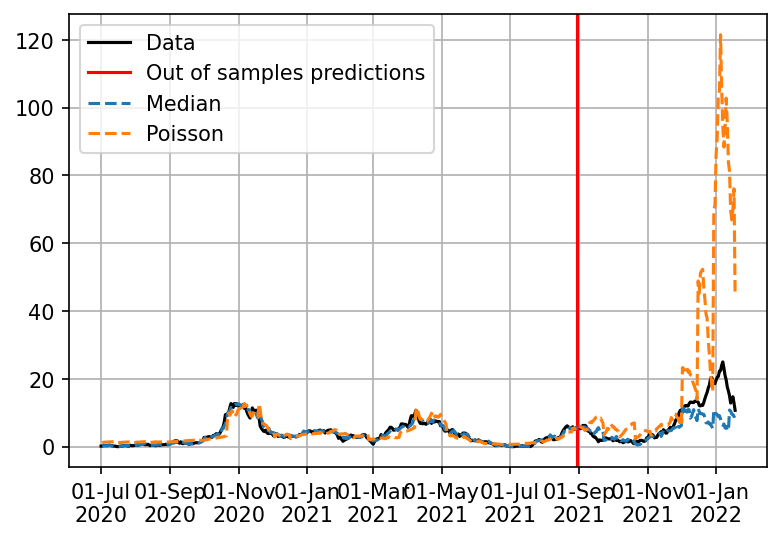

In [90]:
fig, ax = plt.subplots(dpi = 150)

ax.plot(target, label = 'Data', color = 'black')

ax.axvline(target.index[train_size], 0,20,   color = 'red', label = 'Out of samples predictions')

ax.plot(x, y50, label = 'Median', ls = '--')

ax.plot(x, yglm, label = 'Poisson', ls = '--')

ax.xaxis.set_major_formatter(fmt)

ax.grid()

ax.legend()

plt.show()


In [91]:
print(len(target))
print(len(y50))

567
566


In [92]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print('LightGBM')
print('MSE:', mse(target.iloc[train_size +1:].values, y50[train_size:]) )
print('MAE', mae(target.iloc[train_size +1:].values, y50[train_size:]))
print('------------------------------------------------------------------')
print('Poisson')
print('MSE:', mse(target.iloc[train_size +1:].values, yglm[train_size:]) )
print('MAE', mae(target.iloc[train_size +1:].values, yglm[train_size:]))


LightGBM
MSE: 28.079622203005236
MAE 3.0395661279426895
------------------------------------------------------------------
Poisson
MSE: 766.8515313327358
MAE 14.494220312165135


In [93]:
df = pd.DataFrame()

df['LightGBM'] = [mse(target.iloc[train_size +1:].values, y50[train_size:]), mae(target.iloc[train_size +1:].values, y50[train_size:])]

df['Poisson'] = [mse(target.iloc[train_size +1:].values, yglm[train_size:]), mae(target.iloc[train_size +1:].values, yglm[train_size:])]

df.index = ['MSE', 'MAE']

df

,LightGBM,Poisson
MSE,28.079622,766.851531
MAE,3.039566,14.494220
